In [29]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
import operator

load_dotenv()

True

In [30]:
model = ChatGoogleGenerativeAI(model="models/gemini-flash-latest")
model_llama = ChatOllama(model="llama3")
model_qween = ChatOllama(model="qwen3:4b")
model_gema = ChatOllama(model="gemma3")


In [31]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed Feedback for the essay")
    score: int = Field(description="Score out of 10", ge=0, le=10)


In [32]:
structured_model_llama = model_llama.with_structured_output(EvaluationSchema)
structured_model_qween = model_qween.with_structured_output(EvaluationSchema)
structured_model_gema = model_gema.with_structured_output(EvaluationSchema)

In [33]:
essay = """
India is emerging as one of the most influential players in the global artificial intelligence landscape. With a rapidly expanding digital population and widespread smartphone connectivity, the country offers an enormous data ecosystem for AI innovation. Government bodies, private companies, and academic institutions are collectively working to strengthen India’s position as a global AI hub.

A major driver of India’s rise in AI is the government’s strategic focus on digital transformation. Initiatives like Digital India, IndiaAI, and the National Strategy for Artificial Intelligence aim to promote AI research, skill development, and adoption across critical sectors. These programs are designed not only to enhance efficiency but also to solve deep-rooted challenges in health, agriculture, and governance.

India’s tech industry also plays a pivotal role in shaping the nation’s AI capabilities. Leading IT companies such as TCS, Infosys, and Wipro have built advanced AI research centers, helping businesses worldwide automate processes and build intelligent systems. At the same time, startups focused on AI—especially in fintech, healthtech, and edtech—are growing at an unprecedented pace, attracting both local and international investment.

In academia and research, India continues to strengthen its foundation by establishing AI research labs and centers in top institutions. The Indian Institutes of Technology (IITs), Indian Institute of Science (IISc), and various national universities are collaborating with global tech giants to advance AI innovation. These collaborations help create a strong pipeline of skilled professionals and researchers essential for long-term growth.

AI is also playing a critical role in solving societal problems across India. In agriculture, AI tools are helping farmers predict crop diseases and improve yields through precision farming. In healthcare, AI-driven diagnosis and telemedicine tools are improving access to medical support in rural regions, where professional healthcare services are often limited. This highlights India’s unique approach to applying AI for inclusive and sustainable development.

Looking ahead, India’s role in AI is likely to become even more significant due to its young workforce and expanding tech infrastructure. The nation is poised to harness AI not only for economic growth but also for social transformation. With the right balance of innovation, regulation, and ethical development, India has the potential to become one of the world’s leading AI superpowers in the coming decade.
"""

In [34]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"

In [8]:
model_llama.invoke(prompt)

KeyboardInterrupt: 

In [14]:
structured_model_gema.invoke(prompt)

EvaluationSchema(feedback="This is a very well-written and informative essay. Here’s a breakdown of its strengths and areas for minor improvement, followed by a score:\n\n**Strengths:**\n\n* **Clear and Concise:** The writing is clear, easy to understand, and avoids jargon. It presents complex ideas in a straightforward manner.\n* **Well-Organized:** The essay follows a logical structure, moving from a general overview of India's rise in AI to specific examples and future prospects. Each paragraph focuses on a key aspect.\n* **Strong Supporting Evidence:** The essay uses concrete examples – Digital India, IndiaAI, TCS, Infosys, IITs, etc. – to support its claims, making it more convincing.\n* **Positive Tone & Optimistic Outlook:** The essay maintains a positive and optimistic tone, effectively highlighting India’s potential.\n* **Good Use of Examples:** The examples of AI applications in agriculture, healthcare, and fintech are particularly effective in illustrating the impact.\n\n**A

In [42]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [43]:
def evaluate_language(state: UPSCState):
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"

    response = structured_model_llama.invoke(prompt)
    return {'language_feedback': response.feedback, 'individual_scores': [response.score]}

In [44]:
def evaluate_analysis(state: UPSCState):
    prompt = f"Evaluate the depth of analysis the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"

    response = structured_model_qween.invoke(prompt)
    return {'analysis_feedback': response.feedback, 'individual_scores': [response.score]}

In [45]:
def evaluate_thought(state: UPSCState):
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"

    response = structured_model_gema.invoke(prompt)
    return {'clarity_feedback': response.feedback, 'individual_scores': [response.score]}

In [46]:
def final_evaluation(state: UPSCState):
    prompt = f"Based on the following feedbacks create a summarized feedback \n language feedback - {state['language_feedback']} \n depth of analysis feedback - {state['analysis_feedback']} \n clarity of though feedback - {state['clarity_feedback']}"

    overall_feedback = model.invoke(prompt).content

    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])
    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

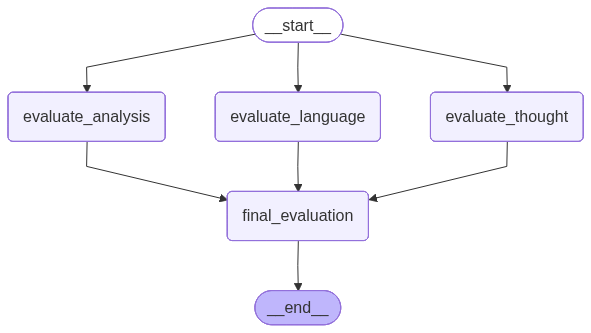

In [47]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)


graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()
workflow


In [48]:
intial_state = { 'essay': essay }
workflow.invoke(intial_state)

{'essay': '\nIndia is emerging as one of the most influential players in the global artificial intelligence landscape. With a rapidly expanding digital population and widespread smartphone connectivity, the country offers an enormous data ecosystem for AI innovation. Government bodies, private companies, and academic institutions are collectively working to strengthen India’s position as a global AI hub.\n\nA major driver of India’s rise in AI is the government’s strategic focus on digital transformation. Initiatives like Digital India, IndiaAI, and the National Strategy for Artificial Intelligence aim to promote AI research, skill development, and adoption across critical sectors. These programs are designed not only to enhance efficiency but also to solve deep-rooted challenges in health, agriculture, and governance.\n\nIndia’s tech industry also plays a pivotal role in shaping the nation’s AI capabilities. Leading IT companies such as TCS, Infosys, and Wipro have built advanced AI r

In [49]:
output = {'essay': '\nIndia is emerging as one of the most influential players in the global artificial intelligence landscape. With a rapidly expanding digital population and widespread smartphone connectivity, the country offers an enormous data ecosystem for AI innovation. Government bodies, private companies, and academic institutions are collectively working to strengthen India’s position as a global AI hub.\n\nA major driver of India’s rise in AI is the government’s strategic focus on digital transformation. Initiatives like Digital India, IndiaAI, and the National Strategy for Artificial Intelligence aim to promote AI research, skill development, and adoption across critical sectors. These programs are designed not only to enhance efficiency but also to solve deep-rooted challenges in health, agriculture, and governance.\n\nIndia’s tech industry also plays a pivotal role in shaping the nation’s AI capabilities. Leading IT companies such as TCS, Infosys, and Wipro have built advanced AI research centers, helping businesses worldwide automate processes and build intelligent systems. At the same time, startups focused on AI—especially in fintech, healthtech, and edtech—are growing at an unprecedented pace, attracting both local and international investment.\n\nIn academia and research, India continues to strengthen its foundation by establishing AI research labs and centers in top institutions. The Indian Institutes of Technology (IITs), Indian Institute of Science (IISc), and various national universities are collaborating with global tech giants to advance AI innovation. These collaborations help create a strong pipeline of skilled professionals and researchers essential for long-term growth.\n\nAI is also playing a critical role in solving societal problems across India. In agriculture, AI tools are helping farmers predict crop diseases and improve yields through precision farming. In healthcare, AI-driven diagnosis and telemedicine tools are improving access to medical support in rural regions, where professional healthcare services are often limited. This highlights India’s unique approach to applying AI for inclusive and sustainable development.\n\nLooking ahead, India’s role in AI is likely to become even more significant due to its young workforce and expanding tech infrastructure. The nation is poised to harness AI not only for economic growth but also for social transformation. With the right balance of innovation, regulation, and ethical development, India has the potential to become one of the world’s leading AI superpowers in the coming decade.\n',
 'language_feedback': "The essay provides a clear and concise overview of India's emergence as a significant player in the global artificial intelligence landscape. The language is straightforward, and the ideas are well-organized, making it easy to follow and understand. However, there are some areas for improvement.",
 'analysis_feedback': "This essay demonstrates solid foundational knowledge of India's AI landscape but lacks the critical depth required for high-scoring analysis. Below is a detailed evaluation with actionable feedback and a score breakdown.",
 'clarity_feedback': "This essay presents a generally clear and well-structured argument about India’s burgeoning role in the global AI landscape. The writing is accessible and avoids overly technical jargon, making it suitable for a broad audience. Here's a breakdown of the strengths and areas for improvement:\n\n**Strengths:**\n\n* **Clear Thesis:** The essay establishes a clear central argument – India is becoming a significant player in AI due to a confluence of factors.\n* **Logical Structure:** The essay flows logically, progressing from a general overview to specific examples and concluding with a forward-looking perspective.\n* **Supporting Evidence:** The essay provides concrete examples of initiatives (Digital India, IndiaAI), companies (TCS, Infosys), and applications (precision farming, telemedicine) to support its claims.\n* **Positive Tone:** The essay maintains an optimistic and confident tone, reflecting India’s potential.\n\n**Areas for Improvement:**\n\n* **Depth of Analysis:** While the essay lists factors contributing to India’s AI rise, it could benefit from a deeper exploration of *why* these factors are so impactful.  For example, it briefly mentions the young workforce, but could expand on the *specific* skills and demographics that are particularly relevant to AI.\n* **Critical Perspective:** The essay leans heavily on a positive view.  Adding a brief acknowledgement of potential challenges – such as data privacy concerns, digital inequality, or the need for robust regulation – would add nuance and credibility.  Simply stating ‘with the right balance’ feels somewhat vague.\n* **Specific Examples:** While the examples are good, one could strengthen the impact by adding a small statistic or quantifiable result. (e.g., “Precision farming techniques, leveraging AI, have increased crop yields by X% in pilot programs.”) \n\n**Scoring:**\n\nI would rate this essay an **8/10**. It’s a solid, informative piece that effectively communicates its central argument. However, it could benefit from a slightly deeper analysis and a touch more critical perspective to elevate it to a 9 or 10. ",
 'overall_feedback': "This essay is a **solid, informative, and highly accessible piece (rated 8/10)** that successfully establishes a clear and optimistic argument regarding India's growing role in the global AI landscape.\n\n**Strengths:**\n\n*   **Exceptional Clarity and Structure:** The language is **straightforward and concise**, making the essay easy to follow. The argument flows logically, supported by a clear thesis and well-organized structure.\n*   **Strong Foundational Evidence:** The essay effectively uses concrete examples of initiatives (like Digital India), companies, and applications (precision farming) to support its claims.\n\n**Primary Area for Improvement: Depth and Criticality**\n\nWhile the essay demonstrates solid foundational knowledge, it **lacks the critical depth** required for high-scoring analysis. To elevate the work, focus on the following:\n\n1.  **Deepen the Analysis:** Move beyond listing contributing factors to critically exploring *why* these factors are so impactful. For instance, delve into the specific skills and demographics of the young workforce that are most relevant to AI development.\n2.  **Incorporate a Critical Perspective:** Add nuance and credibility by briefly acknowledging potential challenges, such as data privacy concerns, regulatory hurdles, or issues of digital inequality.\n3.  **Strengthen Evidence with Quantification:** Enhance the impact of your examples by including **specific statistics or quantifiable results** (e.g., measuring the impact of AI on crop yields in pilot programs).",
 'individual_scores': [7, 7, 8],
 'avg_score': 7.333333333333333}